In [13]:
# prepare
import subprocess
from multiprocessing import Pool, cpu_count
import os, pickle, math, time

import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
sns.color_palette('bright')
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee
import h5py

FW = 600

# You can find the results, plots and saved d
project = "SimpleBulk"
FIGURE_ID = project + '/plots' # save all figures
DATA_ID = project + "/Data" # save design points (model calculations + design parameter)
for it in [project, FIGURE_ID, DATA_ID]:
    os.makedirs(it, exist_ok=True)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(os.path.join(FIGURE_ID, fig_id) + ".png", format='png', dpi=300)
    
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)


In [11]:
# Gaussian emulator

path = 'C:/Users/tiany/AppData/Local/Packages/CanonicalGroupLimited.UbuntuonWindows_79rhkp1fndgsc/LocalState/rootfs/home/tianyu/Bayesian/BayesianAnalysis-Tequila'

simulation = np.loadtxt(path+'/data/dp_output/output')
use_NL = True
Y_model = np.sqrt(simulation) if use_NL else simulation

SS  =  StandardScaler(copy=True)
Npc = 3
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_tf_data = pca.fit_transform(SS.fit_transform(Y_model)) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_tf_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_tf_matrix = inverse_tf_matrix[:Npc,:]


np.savetxt(path+'/data/inverse_tf_matrix', inverse_tf_matrix)
np.savetxt(path+'/data/PCA_transformed_data', pc_tf_data)

design = np.loadtxt(path+'/data/lhd_sampling_3d.txt')
design_max = np.array([1., 0.5, 0.5])
design_min = np.array([0.05, 0.05, 0.05])
design_ptp = np.array([1-0.05, 0.5-0.05, 0.5-0.05])

In [15]:
EMU = path+'/data/emulators.dat'
Emulators=[]
for i in range(0,Npc):
    start_time = time.time()
    kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1e-2, 1e2))) + krnl.WhiteKernel(noise_level=.1, 
                                  noise_level_bounds=(1e-2, 1e2))
    print("-----------------")
    print("Training PC #",i+1)
    GPR=gpr(kernel=kernel,n_restarts_optimizer=5)
    GPR.fit(design, pc_tf_data[:,i].reshape(-1,1))
    print('GPR score: {:1.3f}'.format(GPR.score(design,pc_tf_data[:,i])) )
    print("time: {:1.3f} seconds".format(time.time() - start_time))
    Emulators.append(GPR)
    
with open(EMU, "wb") as f:
    pickle.dump(Emulators,f)

-----------------
Training PC # 1
GPR score: 0.998
time: 0.122 seconds
-----------------
Training PC # 2


C:\Users\tiany\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


GPR score: 0.957
time: 0.162 seconds
-----------------
Training PC # 3
GPR score: 0.239
time: 0.238 seconds


C:\Users\tiany\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
C:\Users\tiany\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 45.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [16]:
Xdim = 3
use_NL = True
def predict_observables(model_parameters, diag_std=False):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """

    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    if len(theta)!=Xdim:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,Xdim)
        for i in range(Npc):
            mn,std=Emulators[i].predict(theta, return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean = mean@inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)    
    variance_matrix = np.diag(np.array(variance).flatten())
    inverse_transformed_variance = np.einsum('ik,kl,lj-> ij', inverse_tf_matrix.T, variance_matrix, inverse_tf_matrix, 
                                             optimize=False)
    if use_NL:
        inverse_transformed_mean = inverse_transformed_mean**2
        inverse_transformed_variance *= np.outer(2.*inverse_transformed_mean[0]**.5, 
                                                 2.*inverse_transformed_mean[0]**.5)
    if diag_std:
        return inverse_transformed_mean[0], np.sqrt(np.diag(inverse_transformed_variance))
    else:
        return inverse_transformed_mean[0], inverse_transformed_variance



In [19]:
X_validation = np.array([[0.3, 0.3, 0.3]])

# Next, get the emulator prediction and uncertainty
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]
np.savetxt(path+'/data/data_predicted', Y_predicted)

In [46]:
y_exp = np.loadtxt(path+'/data/RAA_data')
y_err = np.loadtxt(path+'/data/RAA_data_err')
y_exp_variance = np.diag(y_err**2)

In [47]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

def log_posterior(model_parameters):
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)


In [48]:
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, Xdim)
#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, Xdim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

np.savetxt(path+'/data/MCMC_samples', samples)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 30 walkers
burn in sampling started


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.22it/s]


Mean acceptance fraction: 0.529 (in total 15000 steps)
Burn in completed.
Now running the samples


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.44it/s]


Mean acceptance fraction: 0.534 (in total 60000 steps)


In [49]:
USE_MAP = False
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]

In [50]:
ParameterLabels = ['k', '$\\alpha_s^{hard, elas}$', '$\\alpha_s^{hard, inel}$']
ranges = np.array([[0.05, 1], [0.05, 0.5], [0.05, 0.5]])

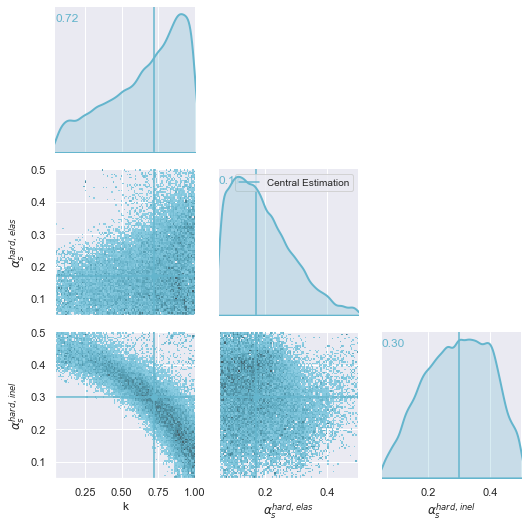

In [51]:

samples_df = pd.DataFrame(samples, columns=ParameterLabels)
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='Central Estimation')
    # ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    # ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=10)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            # g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            # g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/Posterior_of_parameters')

In [54]:
Nsamples = 100
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values

for p in prior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    prior_obs = [np.concatenate(Y_predicted)]

for p in posterior_params: 
    A = np.array([predict_observables(p, diag_std=True)])
    Y_predicted = A[:,0,:]
    posterior_obs = [np.concatenate(Y_predicted)]

In [63]:
pT = np.array([8.25, 8.75, 9.25, 9.75, 11, 13, 15, 17, 19])
Nc = 9

ValueError: operands could not be broadcast together with shapes (9,) (0,) 

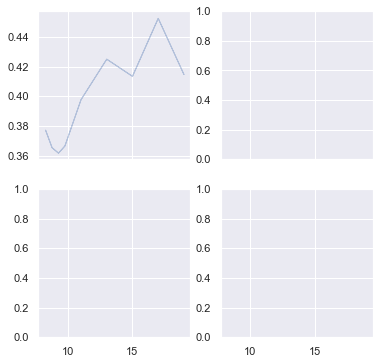

In [64]:
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True)
CLbins = [30,60,90,95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0,0].fill_between(pT, lower[:Nc], upper[:Nc], color=color, alpha=opacity, label=label)
        axes[0,1].fill_between(pT, lower[Nc:], upper[Nc:], color=color, alpha=opacity, label=label)
        axes[1,0].fill_between(pT, (lower/y_exp)[:Nc], (upper/y_exp)[:Nc], color=color, alpha=opacity, label=label)
        axes[1,1].fill_between(pT, (lower/y_exp)[Nc:], (upper/y_exp)[Nc:], color=color, alpha=opacity, label=label)
    
for ax,y,name in zip(axes[0], 
                    [y_exp[:Nc], y_exp[Nc:]],
                    [r"$N_{\rm ch}$", r"$v_2$"]):
    ax.errorbar(cen, y, yerr=y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
    
for ax,y,name in zip(axes[1], 
                    [y_exp[:Nc], y_exp[Nc:]],
                    ["Ratio to pseudo-data$"]*2):
    ax.errorbar(cen, y/y, yerr=y/y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
axes[0,0].semilogy()
axes[0,1].semilogy()
axes[1,0].set_ylim(0,3)
axes[1,1].set_ylim(0,3)
plt.tight_layout()
save_fig("Posterior_validation")

In [40]:
# validate with true values
y_exp = np.loadtxt(path+'/data/true_RAA')
y_err = np.loadtxt(path+'/data/true_RAA_err')
y_exp_variance = np.diag(y_err**2)

In [42]:
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take
# filename = data_path(name+".h5")


#backend = emcee.backends.HDFBackend(filename)
starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, Xdim)
#print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, Xdim, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
    #samples = backend.get_chain(flat=True, discard=nburn)
    samples = sampler.get_chain(flat=True, discard=nburn)

np.savetxt(path+'/data/MCMC_samples', samples)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 30 walkers
burn in sampling started


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.88it/s]


Mean acceptance fraction: 0.462 (in total 15000 steps)
Burn in completed.
Now running the samples


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.15it/s]


Mean acceptance fraction: 0.471 (in total 60000 steps)


In [43]:
true_values = np.array([0.3, 0.3, 0.3])

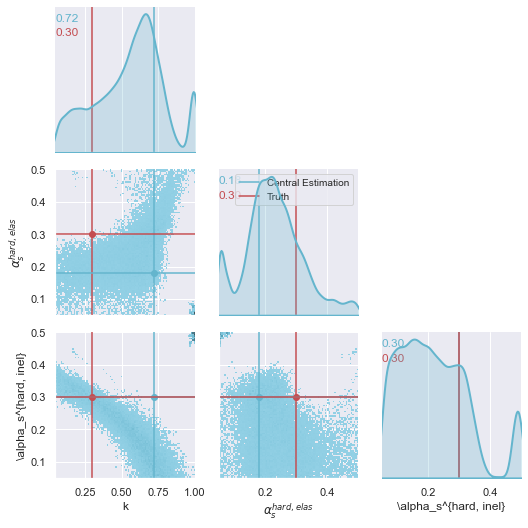

In [44]:
samples_df = pd.DataFrame(samples, columns=ParameterLabels)
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='Central Estimation')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=10)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
plt.savefig(path+'/plots/Posterior_of_true_parameters')